# Counting Crowds with DL
## Proof Of Concept
The notebook will implement [Dense Scale Networks](https://arxiv.org/pdf/1906.09707.pdf) for the purpose of counting crowds for images.
The dataset will be the same as the one, detailed in the paper - the ShangaiTech.

## 1. Imports and loading the data.

In [1]:
import os
import pandas as pd
import numpy as np
import keras
import scipy.io
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import mse, mae

Using TensorFlow backend.


In [2]:
# reporting module
from ovreport.report import report_to_overwatch

### 1.1 Getting Data to Train the model.
A couple of datasets are available to use for the purpose of training. My goal is to try to combine them all and train the dense scale network on all of them and evaluate them on all tests set.

*NOTE*: Provide List of more famous Datasets

#### 1.1.1 UCF-QNRF_ECCV18

#### -- Exploring the data format and images

*TODO:* Learn images original size and aspect ratio.

In [3]:
ucf_qnrf_example = scipy.io.loadmat('training_dataset/UCF-QNRF_ECCV18/Train/img_0001_ann.mat')
print(ucf_qnrf_example.keys())
print(ucf_qnrf_example['annPoints'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'annPoints'])
(433, 2)


Judging from the keys of the example it seems, that the .mat files contain the annotation points. Since my gould is counting the people and not where they are I will take only the count of the annotations and not their respective coordinates.

In [4]:
def build_dataframe(dataset_path):
    '''
        Gets the density/count vector by reading the .mat file 
        and getting the shape of the file. 
        The function only requires the path to the dataset.
    '''
    file_contents = os.listdir(dataset_path)
    only_mat_files = list(filter(lambda x: '.mat' in x, file_contents))
    
    densities = {'image_name':[], 'count': []}
    for mat in only_mat_files:
        filepath = os.path.join(dataset_path, mat)
        mat_loaded = scipy.io.loadmat(filepath)
        # we attach the .jpg at the end for the respective image
        image_name = mat.split('_a')[0] + '.jpg'
        densities['image_name'].append(image_name)
        densities['count'].append(mat_loaded['annPoints'].shape[0])      
    
    # return it as a pandas dataframe
    return pd.DataFrame(densities)

In [5]:
train_df = build_dataframe('training_dataset/UCF-QNRF_ECCV18/Train/')
test_df = build_dataframe('training_dataset/UCF-QNRF_ECCV18/Test/')

In [6]:
train_df.head()

,image_name,count
0,img_0683.jpg,928
1,img_0648.jpg,260
2,img_0560.jpg,108
3,img_0002.jpg,121
4,img_0295.jpg,697


In [7]:
test_df.head()

,image_name,count
0,img_0002.jpg,923
1,img_0295.jpg,1477
2,img_0290.jpg,556
3,img_0174.jpg,259
4,img_0071.jpg,1236


#### -- Keras DataLoader
Some parameters before the definition of the data loaders.

In [8]:
train_batch_size = 32
test_batch_size = 1

##### -- Training & Validation

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1) # we dont have much data as it is
train_iter = train_datagen.flow_from_dataframe(dataframe=train_df,
                                               batch_size=train_batch_size,
                                               directory='training_dataset/UCF-QNRF_ECCV18/Train/',
                                               x_col='image_name',
                                               y_col='count',
                                               subset='training',
                                               target_size=(224, 224),
                                               class_mode='raw')

valid_iter = train_datagen.flow_from_dataframe(dataframe=train_df,
                                               batch_size=test_batch_size,
                                               directory='training_dataset/UCF-QNRF_ECCV18/Train/',
                                               x_col='image_name',
                                               y_col='count',
                                               subset='validation',
                                               target_size=(224, 224),
                                               class_mode='raw')

Found 1081 validated image filenames.
Found 120 validated image filenames.


2047


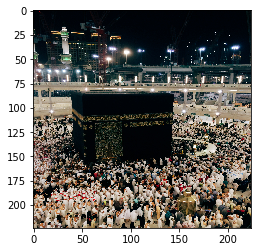

In [10]:
# Show one of the images
x, y = train_iter.next()
for i in range(0,1):
    print(y[i])
    image = x[i]
    plt.imshow(image)
    plt.show()

##### -- Test

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_iter = test_datagen.flow_from_dataframe(dataframe=test_df,
                                               batch_size=test_batch_size,
                                               directory='training_dataset/UCF-QNRF_ECCV18/Test/',
                                               x_col='image_name',
                                               y_col='count',
                                               target_size=(224, 224),
                                               class_mode='raw')

Found 334 validated image filenames.


## 2. Building the Model
In order to build ithe Deep scale network first the Dense Dialated Convolution Block has to be implemented.

### 2.1 Network Architecture
*TODO*: Show pictures from paper

#### 2.1.0 Subclassing API Example
Had some issues with it so I will leave it here for a later point where I can revisit it.

In [12]:
class ConvBlock(keras.models.Model):
    '''
        TODO: Add Docstring
    '''
    def __init__(self, activation='relu', padding=1, dilation_rate=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(256, (1, 1), activation=activation)
        self.padding = keras.layers.ZeroPadding2D(padding=(padding, padding))
        self.conv2 = keras.layers.Conv2D(64, (3, 3), padding='valid', dilation_rate=dilation_rate, activation=activation)
    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.padding(out)
        out = self.conv2(out)
        
        return out    

In [13]:
class DDCB(keras.models.Model):
    '''
        TODO: Add Docstring
    '''
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.convBlock1 = ConvBlock(**kwargs)
        self.convBlock2 = ConvBlock(padding=2, dilation_rate=2, **kwargs)
        self.convBlock3 = ConvBlock(padding=3, dilation_rate=3, **kwargs)
        self.paddingOut = keras.layers.ZeroPadding2D(padding=(1,1))
        self.convOut = keras.layers.Conv2D(512, (3, 3), padding='valid', activation='relu')
    
    def call(inputs):
        out1 = self.convBlock1(inputs)
        out2 = keras.layers.Concatenate([inputs, out1])
        out3 = self.convBlock2(out2)
        out4 = keras.layers.Concatenate([inputs, out1, out3])
        out5 = self.convBlock3(out4)
        out6 = keras.layers.Concatenate([inputs, out3, out5])
        out7 = self.paddingOut(out6)
        out8 = self.convOut(out7)
        return out8 

In [14]:
class DenseScaleNet(keras.models.Model):
    '''
        TODO: Add Docstring
    '''
    def __init__(self, model=None, input_shape=None, **kwargs):
        super().__init__(**kwargs)
        if model is None:
            if input_shape is None:
                raise Exception('A model could not have an input shape set to None.')
                
            model = self.__create_backbone(input_shape)
        
        self.model = model
        self.DDCB1 = DDCB(**kwargs)
        self.DDCB2 = DDCB(**kwargs)
        self.DDCB3 = DDCB(**kwargs)
        self.padding1 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv1 = keras.layers.Conv2D(128, (3, 3), padding='valid', activation='relu')
        self.padding2 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv2 = keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')
        self.outconv = keras.layers.Conv2D(1, (1, 1), activation='relu')
    
    def __create_backbone(self, input_shape):
        '''
            TODO: Add Doctstring
        '''
        vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', input_shape=input_shape)
        model = keras.models.Sequential()
        
        # we want to copy the first ten layers from VGG16
        for layer in vgg16_model.layers[:11]:
            model.add(layer)
        
        return model
        
    def call(self, inputs):
        out1 = self.model(inputs)
        out2 = self.DDCB1(out1)
        out3 = out2 + out3
        out4 = self.DDCB2(out3)
        out5 = out4 + out2 + out1
        out6 = self.DDCB3(out5)
        out7 = out6 + out4 + out2 + out1
        out = self.padding1(out)
        out = self.conv1(out)
        out = self.padding2(out)
        out = self.conv2(out)
        out = self.outconv(out)
        
        return out           

#### 2.1.1 Functional API Implementation

In [15]:
def conv_block(x, activation='relu', padding=1, dilation_rate=1):
    '''
        TODO: Docstring
    '''
    x = keras.layers.Conv2D(256, (1, 1), activation=activation)(x)
    x = keras.layers.ZeroPadding2D(padding=(padding, padding))(x)
    out = keras.layers.Conv2D(64, (3, 3), padding='valid', dilation_rate=dilation_rate, activation=activation)(x)
    
    return out

def ddcb(inputs):
    '''
        TODO: Docstring
    '''
    
    x1 = conv_block(inputs)
    x2 = keras.layers.concatenate([inputs, x1])
    x3 = conv_block(x2, padding=2, dilation_rate=2)
    x4 = keras.layers.concatenate([inputs, x1, x3])
    x5 = conv_block(x4, padding=3, dilation_rate=3)
    x6 = keras.layers.concatenate([inputs, x3, x5])
    x7 = keras.layers.ZeroPadding2D(padding=(1,1))(x6)
    out = keras.layers.Conv2D(512, (3, 3), padding='valid', activation='relu')(x7)
    
    return out

In [23]:
class DenseScaleNetF:
    '''
        TODO: Docstring
    '''
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.backbone = self.__create_backbone(input_shape)
        self.padding1 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv1 = keras.layers.Conv2D(128, (3, 3), padding='valid', activation='relu')
        self.padding2 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv2 = keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')
        self.outconv = keras.layers.Conv2D(1, (1, 1), activation='relu')
    
    def __create_backbone(self, input_shape):
        '''
            TODO: Add Doctstring
        '''
        vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', input_shape=input_shape)
        model = keras.models.Sequential()
        
        # we want to copy the first ten layers from VGG16
        for layer in vgg16_model.layers[:15]:
            model.add(layer)
        
        return model
    
    def build_model(self):
        '''
            TODO: Docstring
        '''
        
        # funny input names to be able to track input and output
        inputs = keras.layers.Input(shape=self.input_shape)
        bckb_x = self.backbone(inputs)
        ddcb1_x = ddcb(bckb_x)
        add1_x = keras.layers.add([ddcb1_x, bckb_x])
        ddcb2_x = ddcb(add1_x)
        add2_x = keras.layers.add([ddcb2_x, ddcb1_x, bckb_x])
        ddcb3_x = ddcb(add2_x)
        add3_x = keras.layers.add([ddcb3_x, ddcb2_x, ddcb1_x, bckb_x])
        pad1_x = self.padding1(add3_x)
        conv1_x = self.conv1(pad1_x)
        pad2_x = self.padding2(conv1_x)
        conv2_x = self.conv2(pad2_x)
        out = self.outconv(conv2_x)
        # create the model
        model = keras.Model(inputs=inputs, outputs=out)
        
        return model

-- Init Model

In [24]:
dsn_model = DenseScaleNetF(input_shape=(224, 224, 3)).build_model()

(?, 14, 14, 1)


### 2.2 Neccessary Callbacks

In [18]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# TODO: Model Saver, Checkpoint Resume

# csv logger for tensorboard
csvlogger = keras.callbacks.CSVLogger(
    filename = 'log/loss_log.log',
    separator=',',
    append=True
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir='log/',
    write_graph=True,
    batch_size=32,
    write_images=True,
    update_freq='batch'
)

In [19]:
calback_list = [
    early_stop,
    csvlogger,
    tensorboard
]

### 2.3 The Optimizer

In [20]:
optimizer = keras.optimizers.Adam()

### 2.4 Custom Loss

**TODO:** Explanation for the custom loss from the paper

In [ ]:
def dsn_loss(y_true, y_pred):
    Le = keras.losses.mean_squared_error(y_true, y_pred)
    Lc = keras.losses.mean_absolute_error(y_true, y_pred)
    

### 2.5 Model Compilation & Summary

In [21]:
dsn_model.compile(loss=keras.losses.mean_squared_error,
                 optimizer=optimizer,
                 metrics=[keras.metrics.mean_squared_error])
dsn_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 14, 14, 512)  7635264     input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 256)  131328      sequential_1[1][0]               
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 16, 16, 256)  0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 

### 2.6 Fitting the model to the data.

In [29]:
dsn_model.fit_generator(train_iter,
                       steps_per_epoch = len(train_iter),
                       epochs = 5,
                       validation_data=valid_iter,
                       validation_steps=len(valid_iter),
                       callbacks=calback_list
                       )